In [625]:
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import sys
from urllib.parse import urlparse
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

#This will return last modified time of given web page url
def get_last_modified(url):
    result = urlparse(url)
    if True if [result.scheme, result.netloc, result.path] else False:
        header = requests.head(url).headers
        if 'Last-Modified' in header:
            return header['Last-Modified']
        print ("Data is not available")
        return -1
    else:
        return -1

def getNeedNewFile(last_modified):
    text_file = open("lastmodified.txt", "r")
    previous_modified = text_file.read()
    text_file.close()
    if last_modified == previous_modified:
        return False
    else:
        return True

def addLastModified(last_modified):
    text_file = open("lastmodified.txt", "w")
    text_file.write(last_modified)
    text_file.close()
    text_file2 = open("toTweet.txt", "w")
    text_file2.write("Yes")
    text_file2.close()
    
def DownloadAndSaveFile(url,filename):
    import urllib.request 
    urllib.request.urlretrieve(url, filename)
    

#2020 population of Catalonia from https://www.idescat.cat/pub/?id=aec&n=245
popCatalunya = 7722203
color1stdose = "springgreen"
color2ndose = "seagreen"
colorcases = "tomato"
colorICU = "cadetblue"
colorDeaths= "black"


In [626]:
#Catalonia's health department data https://dadescovid.cat/descarregues
urldatafile = "https://dadescovid.cat/static/csv/catalunya_diari_total_pob.zip"
urldatafile2 = "https://dadescovid.cat/static/csv/regio_diari_total_pob.zip"
datafile = "data/catalunya_diari_total_pob.zip"
datafile2 = "data/regio_diari_total_pob.zip"

last_modified = get_last_modified(urldatafile)
toget = getNeedNewFile(last_modified)
print("Download new file?", toget)
if toget:
    DownloadAndSaveFile(urldatafile,datafile)
    DownloadAndSaveFile(urldatafile2,datafile2)
    addLastModified(last_modified)
    
df = pd.read_csv(datafile, sep=";")
dfreg = pd.read_csv(datafile2, sep=";")

last_update = max(df["DATA"])
#df.head()

Download new file? False


**Check if new data has been added to the source file**

In [627]:
previousdf_columns = ['NOM',
 'CODI',
 'DATA',
 'SEXE',
 'GRUP_EDAT',
 'CASOS_CONFIRMAT',
 'PCR',
 'TAR',
 'INGRESSOS_TOTAL',
 'INGRESSOS_CRITIC',
 'INGRESSATS_TOTAL',
 'INGRESSATS_CRITIC',
 'EXITUS',
 'CASOS_PCR',
 'CASOS_TAR',
 'POSITIVITAT_PCR_NUM',
 'POSITIVITAT_TAR_NUM',
 'POSITIVITAT_PCR_DEN',
 'POSITIVITAT_TAR_DEN',
 'VACUNATS_DOSI_1',
 'VACUNATS_DOSI_2']
assert list(df.columns) == previousdf_columns, "Source data has changed format"

In [628]:
df["DATA"] = pd.to_datetime(df["DATA"])
dfagg = df.groupby("DATA").agg(sum)
#dfagg.tail()

**Date of first vaccination recorded**

In [629]:
first_vaccination_date=min(dfagg.index[dfagg.VACUNATS_DOSI_1>0])
first_vaccination_date

Timestamp('2020-12-27 00:00:00')

In [630]:
dfaggvac = dfagg[dfagg.index>=first_vaccination_date]
dfaggvac.reset_index(inplace=True)
dfaggvac['Weekend'] = np.where(dfaggvac["DATA"].dt.weekday < 5,0,1)
dfaggvac["1st dose percent"] = dfaggvac["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
dfaggvac["2nd dose percent"] = dfaggvac["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
#dfaggvac.head()

In [631]:
tidy = dfaggvac[["DATA","VACUNATS_DOSI_1","VACUNATS_DOSI_2"]]
tidy.columns = ["DATA","1st","2nd"]
tidy = tidy.melt(id_vars="DATA",ignore_index = False).rename(columns=str.title)
tidy.rename(columns = {'Variable': 'Dose'} , inplace=True)
tidy['Data'] = tidy['Data'].dt.strftime('%d-%b')

In [632]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
sns.set_style("ticks")

Extrapolate from last week number of vaccinations, when will all the Catalan population be vaccinated

In [633]:
import datetime
lastweek = dfaggvac.tail(7)
popCatalunya70 = int(round(popCatalunya*0.7))
vaccperday = np.average(lastweek["VACUNATS_DOSI_2"]) + np.average(lastweek["VACUNATS_DOSI_1"])
nonvaccinated = popCatalunya*(1 -  lastweek.loc[lastweek.index[-1], "2nd dose percent"] /100) + popCatalunya*(1 -  lastweek.loc[lastweek.index[-1], "1st dose percent"] /100)
nonvaccinated70 = popCatalunya70*2 - (2*popCatalunya-nonvaccinated)

days_to_end_vaccination = nonvaccinated/vaccperday
days_to_end_vaccination70  = nonvaccinated70/vaccperday

vaccination_end = (max(dfaggvac["DATA"]) + datetime.timedelta(days=days_to_end_vaccination)).strftime("%Y-%m-%d")
vaccination_end70 = (max(dfaggvac["DATA"]) + datetime.timedelta(days=days_to_end_vaccination70)).strftime("%Y-%m-%d")

print (vaccperday, days_to_end_vaccination, vaccination_end, nonvaccinated, popCatalunya)
print(vaccperday, days_to_end_vaccination70, vaccination_end70, nonvaccinated70, popCatalunya70)


18314.14285714286 800.169907721589 2023-05-17 14654426.0 7722203
18314.14285714286 547.1784335291227 2022-09-06 10021104.0 5405542


<IPython.core.display.Javascript object>


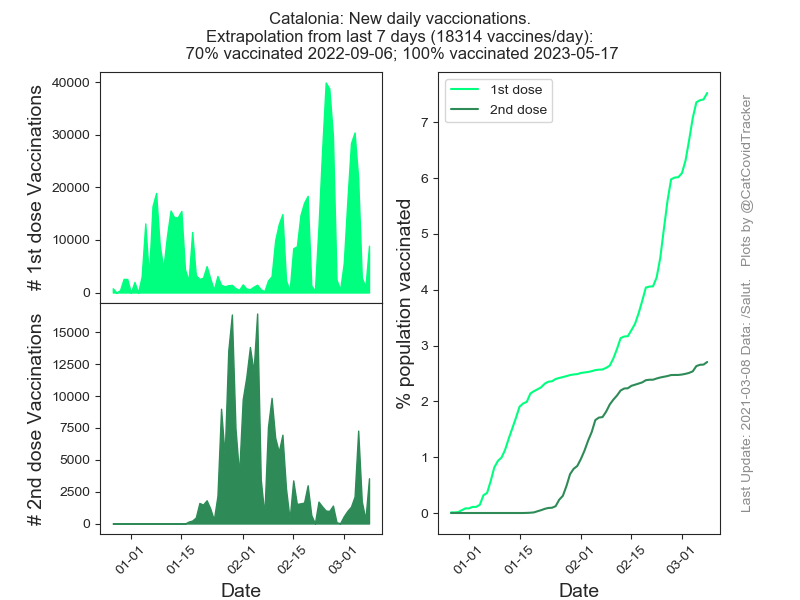

In [634]:
fig = plt.figure(figsize=(8, 6))

gs = fig.add_gridspec(2,2)

date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.suptitle("Catalonia: New daily vaccionations."+
            "\nExtrapolation from last 7 days (" + str(int(vaccperday)) +" vaccines/day):\n 70% vaccinated " + vaccination_end70 + "; 100% vaccinated " + vaccination_end)

# Defining custom 'xlim' and 'ylim' values.
maxx = max(dfaggvac["VACUNATS_DOSI_1"].max(),dfaggvac["VACUNATS_DOSI_2"].max())
custom_ylim = (0, maxx+1000)

# Setting the values for all axes.
#plt.setp(ax1, ylim=custom_ylim)

ax1 = fig.add_subplot(gs[0, 0])

#ax1.bar(x="DATA", height="VACUNATS_DOSI_1",data=dfaggvac, color=color1stdose)
ax1.fill_between(dfaggvac["DATA"], 0, dfaggvac["VACUNATS_DOSI_1"], color=color1stdose)

ax1.set_ylabel("# 1st dose Vaccinations",fontsize=14)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax2 = fig.add_subplot(gs[1, 0]) 

#ax2.bar(x="DATA", height="VACUNATS_DOSI_2",data=dfaggvac, color=color2ndose)
ax2.fill_between(dfaggvac["DATA"], 0, dfaggvac["VACUNATS_DOSI_2"], color=color2ndose)

ax2.set_xlabel("Date",fontsize=14)
ax2.set_ylabel("# 2nd dose Vaccinations",fontsize=14)
ax2.xaxis.set_major_formatter(date_form)
ax2.tick_params(axis="x",rotation=45)

ax3 = fig.add_subplot(gs[:, 1])

ax3.plot(dfaggvac["DATA"], dfaggvac["1st dose percent"], color=color1stdose, label="1st dose")
ax3.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color=color2ndose, label="2nd dose")

ax3.set_xlabel("Date",fontsize=14)
ax3.set_ylabel("% population vaccinated",fontsize=14)
ax3.xaxis.set_major_formatter(date_form)
ax3.legend()
ax3.tick_params(axis="x",rotation=45)

ax3.text(1.1, 0.5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax3.transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')

plt.show()
plt.savefig('CurrentOverallVaccinationCat.png')

<IPython.core.display.Javascript object>


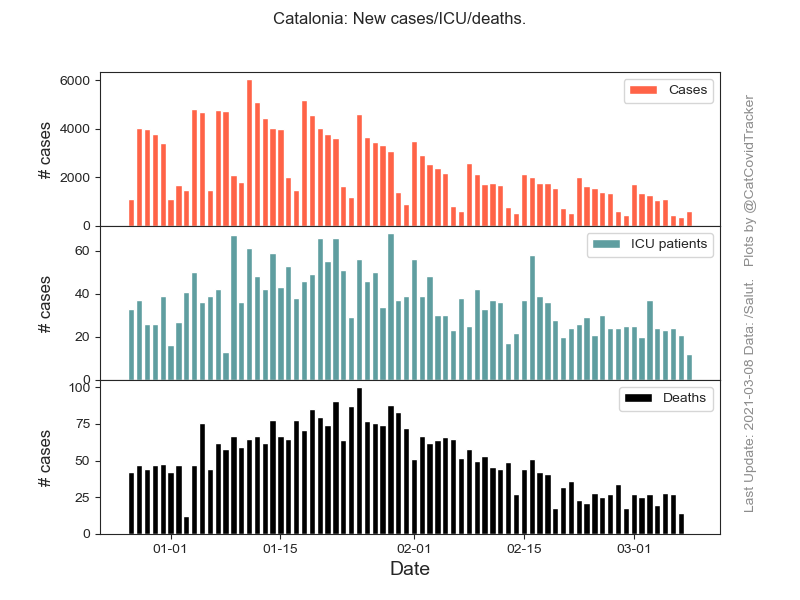

In [635]:
fig3, ax3 = plt.subplots(3,1,figsize=(8, 6), sharex=True)
date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig3.subplots_adjust(hspace=0)
fig3.suptitle("Catalonia: New cases/ICU/deaths.")

ax3[0].bar(x="DATA", height="CASOS_CONFIRMAT",data=dfaggvac, color=colorcases)
ax3[0].set_ylabel("# cases",fontsize=12)
ax3[0].legend(["Cases"])

ax3[1].bar(x="DATA", height="INGRESSOS_CRITIC",data=dfaggvac, color=colorICU)
ax3[1].set_ylabel("# cases",fontsize=12)
ax3[1].legend(["ICU patients"])

ax3[2].bar(x="DATA", height="EXITUS",data=dfaggvac, color=colorDeaths)
ax3[2].set_xlabel("Date",fontsize=14)
ax3[2].set_ylabel("# cases",fontsize=12)
ax3[2].legend(["Deaths"])

ax3[2].xaxis.set_major_formatter(date_form)

ax3[2].text(1.05, 1.5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax3[2].transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')

fig3.align_ylabels()

plt.show()
plt.savefig('CurrentCasesICUDeathsCat.png')

In [636]:
dfage = df.groupby(["DATA","GRUP_EDAT"]).agg(sum)
#dfage.head()
#Població per sexe i grups d'edat: https://www.idescat.cat/pub/?id=aec&n=253


In [637]:
#Downloaded from https://www.idescat.cat/pub/?id=aec&n=253
popdf = pd.read_html("data/aec-253.xls")
popdf = popdf[0]
popdf = popdf[:-4]
popdf = popdf[["Unnamed: 0", "Homes", "Dones", "Total"]]
popdf.rename(columns={"Unnamed: 0":"Age range", "Homes" : "Men", "Dones":"Women"},inplace=True)
popdf.replace({'\.':''}, regex=True,inplace=True)
popdf = popdf.astype({'Men': 'int64','Women': 'int64','Total': 'int64'})
popdf

,Age range,Men,Women,Total
0,De 0 a 4 anys,177639,168224,345863
1,De 5 a 9 anys,207060,194449,401509
2,De 10 a 14 anys,223267,208376,431643
3,De 15 a 19 anys,210527,193260,403787
4,De 20 a 24 anys,205008,191087,396095
5,De 25 a 29 anys,221110,216044,437154
6,De 30 a 34 anys,231001,235104,466105
7,De 35 a 39 anys,270896,274488,545384
8,De 40 a 44 anys,334557,325651,660208
9,De 45 a 49 anys,324031,313261,637292


In [638]:
popranges = np.sum(popdf.loc[0:3,"Total"]), np.sum(popdf.loc[3:13,"Total"]), np.sum(popdf.loc[13:15,"Total"]),np.sum(popdf.loc[15:,"Total"])
popranges = pd.Series(popranges,index=['Menors de 15','Entre 15 i 64', 'Entre 65 i 74', 'Majors de 74'])
popranges

Menors de 15     1582802
Entre 15 i 64    5462530
Entre 65 i 74    1016572
Majors de 74      725118
dtype: int64

In [639]:
dfage.reset_index(inplace=True)
dfage

,DATA,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,2020-03-01,Entre 15 i 64,1,12,0,0,0,0,0,0,1,0,0,0,12,0,0,0
1,2020-03-01,Entre 65 i 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
2,2020-03-01,Majors de 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
3,2020-03-01,Menors de 15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-02,Entre 15 i 64,4,25,0,0,0,0,0,0,4,0,2,0,25,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,2021-03-07,Menors de 15,37,541,345,0,0,3,0,0,24,13,26,11,525,332,0,0
1488,2021-03-08,Entre 15 i 64,463,1721,3931,0,6,604,186,0,42,421,44,324,1510,3733,8060,3107
1489,2021-03-08,Entre 65 i 74,56,438,433,1,3,384,120,0,3,53,5,47,401,406,115,122
1490,2021-03-08,Majors de 74,43,675,486,4,3,495,59,0,8,35,8,34,580,435,710,315


In [640]:
dfage = dfage[dfage.DATA>=first_vaccination_date]
aggAgedf = []
for x in popranges.index:
    x1 = dfage[dfage.GRUP_EDAT==x]
    x1["1st dose percent"] =  x1["VACUNATS_DOSI_1"].cumsum()/popranges[x]*100
    x1["2nd dose percent"] =  x1["VACUNATS_DOSI_2"].cumsum()/popranges[x]*100
    
    aggAgedf.append(x1)

<IPython.core.display.Javascript object>


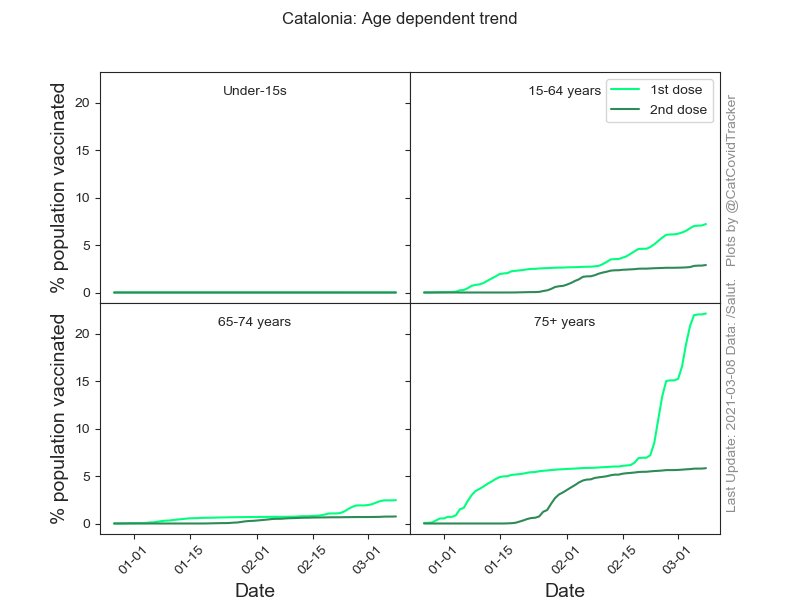

0 0 1
0 1 2
1 0 3
1 1 4


In [641]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8,6))

fig.suptitle("Catalonia: Age dependent trend")

eachtitle = ["Under-15s","15-64 years","65-74 years", "75+ years"]
k=0
for i in range(2):
    for j in range(2):
        
        axs[i][j].plot(aggAgedf[k]["DATA"], aggAgedf[k]["1st dose percent"], color=color1stdose, label="1st dose")
        axs[i][j].plot(aggAgedf[k]["DATA"], aggAgedf[k]["2nd dose percent"], color=color2ndose, label="2nd dose")
        axs[i][j].set_xlabel("Date",fontsize=14)
        if(k%2==0): axs[i][j].set_ylabel("% population vaccinated",fontsize=14)
        axs[i][j].xaxis.set_major_formatter(date_form)    
        axs[i][j].tick_params(axis="x",rotation=45)
        if(k%2==0): axs[i][j].tick_params(axis="y")
        #axs[i][j].title.set_text(eachtitle[k])
        axs[i][j].text(.5, .9,eachtitle[k], transform=axs[i][j].transAxes,ha='center')
        if(k==1): axs[i][j].legend()
        k=k+1
        print(i,j,k)
#a.legend()

axs[i][j].text(1.04, 1., "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=axs[i][j].transAxes,
        fontsize=10, color='gray', alpha=0.9,
       ha='center', va='center', rotation='90')

fig.subplots_adjust(wspace=0, hspace=0)

plt.show()
plt.savefig('CurrentByAgeVaccinationCat.png')

**Data by region**

In [642]:
#https://dadescovid.cat/static/csv/regio_diari_total_pob.zip
#Catalonia's health department data https://dadescovid.cat/descarregues

#dfreg.head()

In [643]:
regions = dfreg["NOM"].unique()
dfreg["DATA"] = pd.to_datetime(dfreg["DATA"])
dfreg = dfreg[dfreg.DATA>=first_vaccination_date]
dfregagg = dfreg.groupby(["NOM","DATA"]).agg(sum)
#dfregagg.head()

In [644]:
#regions

#Population data from https://catsalut.gencat.cat/web/.content/minisite/catsalut/proveidors_professionals/registres_catalegs/documents/poblacio-referencia.pdf

**Regions sanitàries Població**

Alt Pirineu i Aran 67.277

Lleida 362.850

Camp de Tarragona 607.999

Terres de l'Ebre 176.817

Girona 861.753

Catalunya Central 526.959

Barcelona 5.050.190

    Àmbit Territorial Barcelona Ciutat 1.693.449
    Àmbit Territorial Metropolità Nord 1.986.032
    Àmbit Territorial Metropolità Sud 1.370.709

Total Catalunya 7.653.845

In [645]:
popregions = pd.Series([67277, 1693449,607999,526959,861753,362850,1986032,1370709,176817],index=regions)
popregions

ALT PIRINEU I ARAN      67277
BARCELONA CIUTAT      1693449
CAMP DE TARRAGONA      607999
CATALUNYA CENTRAL      526959
GIRONA                 861753
LLEIDA                 362850
METROPOLITANA NORD    1986032
METROPOLITANA SUD     1370709
TERRES DE L'EBRE       176817
dtype: int64

In [646]:
dfregagg.reset_index(inplace=True)
dfregagg.set_index("NOM",inplace=True)
dfregagg

,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
NOM,,,,,,,,,,,,,,,,,,
ALT PIRINEU I ARAN,2020-12-27,568,15,53,31,3,1,18,5,0,6,9,5,8,44,27,80,0
ALT PIRINEU I ARAN,2020-12-28,568,39,288,165,7,2,22,7,0,19,20,18,14,246,161,0,0
ALT PIRINEU I ARAN,2020-12-29,568,59,216,194,0,0,23,7,0,15,44,16,44,171,184,48,0
ALT PIRINEU I ARAN,2020-12-30,568,45,140,261,3,0,24,7,0,14,31,12,30,123,244,93,0
ALT PIRINEU I ARAN,2020-12-31,568,79,362,193,4,1,23,6,1,29,50,39,46,326,189,107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TERRES DE L'EBRE,2021-03-04,504,7,370,128,1,0,19,12,0,0,7,1,6,342,125,1019,1
TERRES DE L'EBRE,2021-03-05,504,6,446,115,0,0,17,10,0,2,4,2,4,417,111,339,191
TERRES DE L'EBRE,2021-03-06,504,2,37,50,0,0,15,10,0,1,1,1,1,32,48,15,67


In [647]:
dfregagg['Weekend'] = np.where(dfregagg["DATA"].dt.weekday < 5,0,1)
dfregagg['1st dose percent'] = dfregagg.groupby("NOM")['VACUNATS_DOSI_1'].transform(pd.Series.cumsum)
dfregagg['2nd dose percent'] = dfregagg.groupby("NOM")['VACUNATS_DOSI_2'].transform(pd.Series.cumsum)


#dfregagg["1st dose percent"] = dfregagg["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
#dfregagg["2nd dose percent"] = dfregagg["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
dfregagg['1st dose percent'] = dfregagg['1st dose percent']*100/popregions[dfregagg.index]
dfregagg['2nd dose percent'] = dfregagg['2nd dose percent']*100/popregions[dfregagg.index]

In [648]:
#dfregagg.tail()

<IPython.core.display.Javascript object>


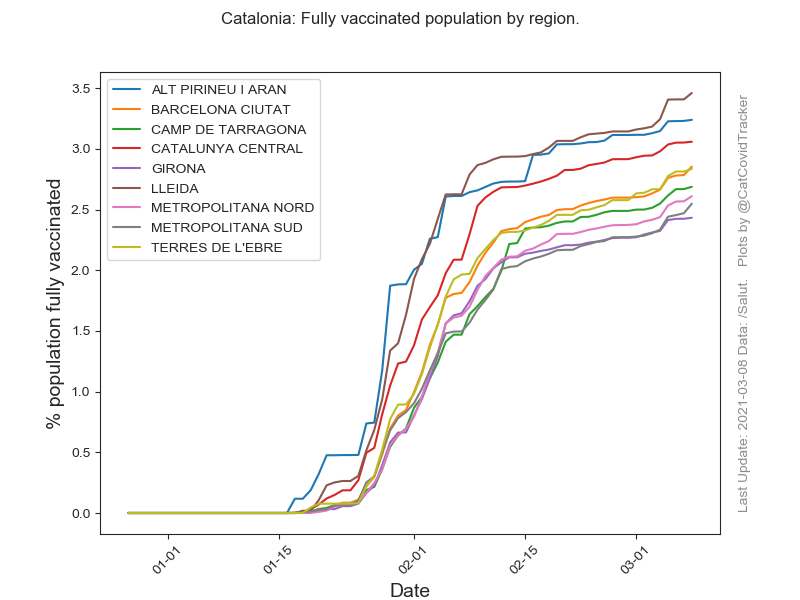

In [649]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle("Catalonia: Fully vaccinated population by region.")
ax = sns.lineplot(x="DATA",y="2nd dose percent",data=dfregagg,hue="NOM",)
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% population fully vaccinated",fontsize=14)
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)

ax.text(1.04, 0.5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax.transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')
plt.savefig('CurrentRegionVaccinationCat.png')

**Fully vaccinated vs people in hospitalized and ICU patients currently in hospital**

In [650]:
#dfaggvac.head()

<IPython.core.display.Javascript object>


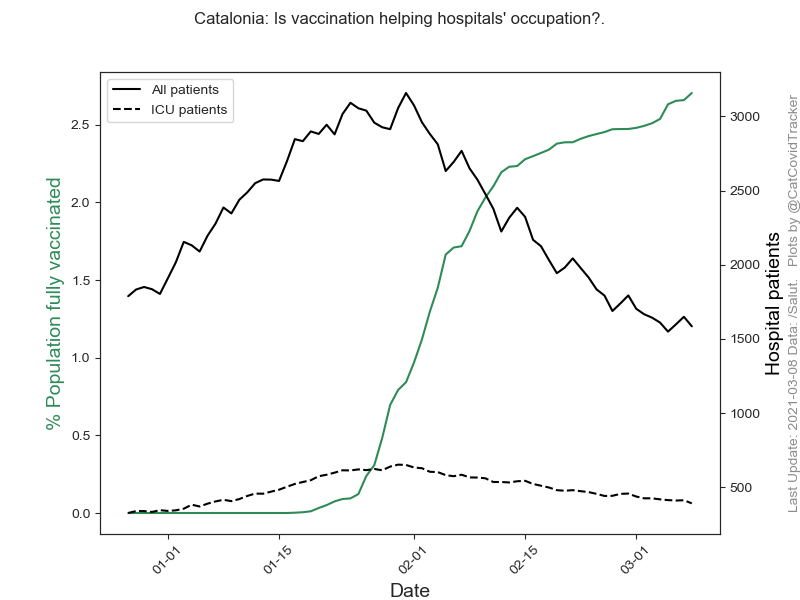

In [651]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Catalonia: Is vaccination helping hospitals' occupation?.")

# make a plot
ax.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color=color2ndose, label="Fully vaccinated rate")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("% Population fully vaccinated",color=color2ndose,fontsize=14)
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.tick_params(axis="x",rotation=45)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dfaggvac["DATA"], dfaggvac["INGRESSATS_TOTAL"], color="black", label="All patients")
ax2.plot(dfaggvac["DATA"], dfaggvac["INGRESSATS_CRITIC"], '--', color="black", label="ICU patients")

ax2.set_ylabel("Hospital patients",color="black",fontsize=14)
ax2.xaxis.set_major_formatter(DateFormatter("%m-%d"))

ax2.legend(loc='upper left')
ax.text(1.12, .5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax2.transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')
plt.show()
plt.savefig('HospitalVSVaccinationCat.png')

In [652]:
dflast = dfregagg[dfregagg.DATA==last_update]

a=(dflast.loc["BARCELONA CIUTAT"]["2nd dose percent"]*popregions["BARCELONA CIUTAT"] 
+ dflast.loc["METROPOLITANA NORD"]["2nd dose percent"]*popregions["METROPOLITANA NORD"]
+ dflast.loc["METROPOLITANA SUD"]["2nd dose percent"]*popregions["METROPOLITANA SUD"])

b=(popregions["BARCELONA CIUTAT"]+popregions["METROPOLITANA NORD"]+popregions["METROPOLITANA SUD"])
dfaux = pd.DataFrame({'2nd dose percent':a/b},index=["BARCELONA"])
dflast = dflast.append(dfaux)
dflast = dflast.drop(["BARCELONA CIUTAT", "METROPOLITANA NORD", "METROPOLITANA SUD"])
dflast.reset_index(inplace=True)
dflast.rename(columns={"index":"NOMRS"}, inplace=True)
#dflast.head()

In [653]:
import geopandas as gpd
dfmap=gpd.read_file("shapefile/ABS_2018/RegionsS_2018.shp")
dfmap["NOMRS"] = dfmap["NOMRS"].str.replace("Regió Sanitària ", '').str.upper()
dfmap["NAME"] = dfmap["NOMRS"]
dfmap.at[0, 'NAME'] = "CAMP DE\nTARRAGONA"
dfmap.at[3, 'NAME'] = "CATALUNYA\nCENTRAL"
dfmap.at[4, 'NAME'] = "TERRES DE\nL'EBRE"
dfmap.at[5, 'NAME'] = "ALT PIRINEU\nI ARAN"

In [654]:
dfmap = dfmap.merge(dflast[["NOMRS","2nd dose percent"]])
dfmap.head(10)

,CODIRS,NOMRS,ÀREA,geometry,NAME,2nd dose percent
0,62,CAMP DE TARRAGONA,2.755252e+09,"MULTIPOLYGON (((323341.750 4538212.510, 323344...",CAMP DE\nTARRAGONA,2.687011
1,64,GIRONA,5.765363e+09,"MULTIPOLYGON (((470266.440 4606110.290, 470267...",GIRONA,2.432368
2,78,BARCELONA,2.954231e+09,"MULTIPOLYGON (((395337.879 4563748.012, 395336...",BARCELONA,2.674672
3,67,CATALUNYA CENTRAL,6.067787e+09,"POLYGON ((359427.518 4594965.930, 359390.449 4...",CATALUNYA\nCENTRAL,3.058682
4,63,TERRES DE L'EBRE,3.355167e+09,"MULTIPOLYGON (((293729.790 4495731.740, 293731...",TERRES DE\nL'EBRE,2.834569
5,71,ALT PIRINEU I ARAN,5.782987e+09,"MULTIPOLYGON (((360797.149 4650206.542, 360960...",ALT PIRINEU\nI ARAN,3.238848
6,61,LLEIDA,5.424543e+09,"POLYGON ((319752.200 4581218.100, 319337.600 4...",LLEIDA,3.459832


<IPython.core.display.Javascript object>


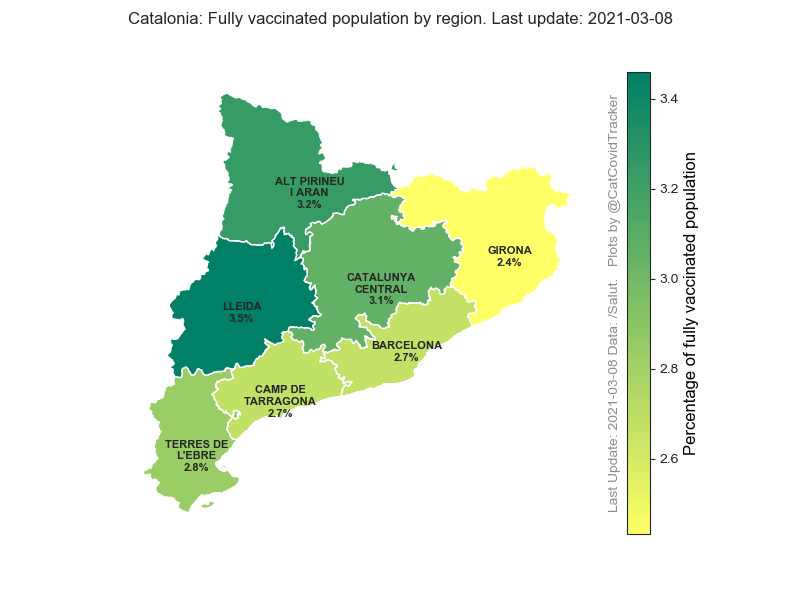

In [655]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Catalonia: Fully vaccinated population by region."")
ax.axis("off")
color_map = plt. cm. get_cmap('summer')
reversed_color_map = color_map. reversed() 

dfmap.plot(ax=ax,column='2nd dose percent',  legend=True,cmap=reversed_color_map,  
#           legend_kwds={'label': 'Percentage of fully vaccinated population'},
#           vmin=0,vmax=min(100,1+max(dfmap["2nd dose percent"])))
           vmax=min(100,0+max(dfmap["2nd dose percent"])))


dfmap['coords'] = dfmap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfmap['coords'] = [coords[0] for coords in dfmap['coords']]

dfmap['NAMEvac'] = dfmap['NAME'] +"\n"+ round(dfmap["2nd dose percent"],1).astype(str) + "%"
for idx, row in dfmap.iterrows():
    plt.annotate(s=row['NAMEvac'], xy=row['coords'],
                 horizontalalignment='center', fontsize = 8,fontweight='bold',verticalalignment="top")
ax.text(1.04, 0.5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax.transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')
ax.text(1.2, 0.5, "Percentage of fully vaccinated population", transform=ax.transAxes,
        fontsize=12, color='black', 
        ha='center', va='center', rotation='90')

plt.savefig('MapCurrentRegionVaccinationCat.png')

***Vacunació per al COVID-19 per àrea bàsica de salut***

https://analisi.transparenciacatalunya.cat/Salut/Vacunaci-per-al-COVID-19-per-rea-b-sica-de-salut/tp23-dey4

Aquestes dades provenen de diversos sistemes d'informació del Departament de Salut i del Servei Català de la Salut, detallats a https://dadescovid.cat/documentacio , i mostren per a cada dia, àrea bàsica de salut, sexe i grup d'edat, el nombre de dosis administrades de vacunes per al SARS-CoV-2, amb el detall del producte administrat i del número de dosi, i també el nombre de persones citades en la data de referència per a ser vacunades i per a les quals se n'ha descartat la vacunació, per algun d'aquests motius: per rebuig del pacient, per estar contraindicada la immunització o bé perquè el pacient ha passat la malaltia.

En els casos en què no ha estat possible identificar l'àrea bàsica de salut de residència de la persona a qui s'ha administrat la dosi, o de qui se n'ha descartat la vacunació, el valor de la variable 'ABS' és 'No classificat'.

In [656]:
urldatafile3 = "https://analisi.transparenciacatalunya.cat/api/views/tp23-dey4/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true"
datafile3 = "data/Vacunaci__per_al_COVID-19_per__rea_b_sica_de_salut.csv"
if toget:
    DownloadAndSaveFile(urldatafile3,datafile3)
casesdf = pd.read_csv(datafile3, sep=";")
casesdf.head()

,SEXE_CODI,SEXE,REGIO_CODI,REGIO,SECTOR_CODI,SECTOR,AGA_CODI,AGA,ABS_CODI,ABS,EDAT,DOSI,DATA,FABRICANT,NO_VACUNAT,RECOMPTE
0,0.0,Home,7801.0,METROPOLITANA SUD,7866.0,BAIX LLOBREGAT CENTRE-LITORAL I L'H,24.0,Baix Llobregat Centre i Fontsanta -L'H N,213.0,SANT JOAN DESPÍ 1,75 o més,1,18/02/2021,BioNTech / Pfizer,NaN,3
1,1.0,Dona,6700.0,CATALUNYA CENTRAL,6735.0,ANOIA,19.0,Anoia,372.0,IGUALADA-2,15 a 64,1,11/01/2021,BioNTech / Pfizer,NaN,21
2,1.0,Dona,7802.0,METROPOLITANA NORD,7843.0,VALLÈS OCCIDENTAL OEST,66.0,Vallès Occidental Oest,388.0,SANT CUGAT DEL VALLÈS-1,15 a 64,1,22/02/2021,Moderna / Lonza,NaN,5
3,0.0,Home,6400.0,GIRONA,6461.0,GIRONA NORD,51.0,Alt Empordà,80.0,BÀSCARA,75 o més,1,05/03/2021,BioNTech / Pfizer,NaN,11
4,1.0,Dona,7803.0,BARCELONA CIUTAT,7850.0,BARCELONA SARRIÀ-SANT GERVASI,46.0,Barcelona Esquerra,45.0,BARCELONA 5-D,15 a 64,1,14/01/2021,BioNTech / Pfizer,NaN,25


In [657]:
casesdf.loc[casesdf['NO_VACUNAT'] == "No vacunat", 'VACUNAT'] = 0
casesdf.loc[casesdf['NO_VACUNAT'].isna(), 'VACUNAT'] = 1
casesdf.head()

,SEXE_CODI,SEXE,REGIO_CODI,REGIO,SECTOR_CODI,SECTOR,AGA_CODI,AGA,ABS_CODI,ABS,EDAT,DOSI,DATA,FABRICANT,NO_VACUNAT,RECOMPTE,VACUNAT
0,0.0,Home,7801.0,METROPOLITANA SUD,7866.0,BAIX LLOBREGAT CENTRE-LITORAL I L'H,24.0,Baix Llobregat Centre i Fontsanta -L'H N,213.0,SANT JOAN DESPÍ 1,75 o més,1,18/02/2021,BioNTech / Pfizer,NaN,3,1.0
1,1.0,Dona,6700.0,CATALUNYA CENTRAL,6735.0,ANOIA,19.0,Anoia,372.0,IGUALADA-2,15 a 64,1,11/01/2021,BioNTech / Pfizer,NaN,21,1.0
2,1.0,Dona,7802.0,METROPOLITANA NORD,7843.0,VALLÈS OCCIDENTAL OEST,66.0,Vallès Occidental Oest,388.0,SANT CUGAT DEL VALLÈS-1,15 a 64,1,22/02/2021,Moderna / Lonza,NaN,5,1.0
3,0.0,Home,6400.0,GIRONA,6461.0,GIRONA NORD,51.0,Alt Empordà,80.0,BÀSCARA,75 o més,1,05/03/2021,BioNTech / Pfizer,NaN,11,1.0
4,1.0,Dona,7803.0,BARCELONA CIUTAT,7850.0,BARCELONA SARRIÀ-SANT GERVASI,46.0,Barcelona Esquerra,45.0,BARCELONA 5-D,15 a 64,1,14/01/2021,BioNTech / Pfizer,NaN,25,1.0


In [658]:
vacc_ratio = casesdf.groupby(["REGIO","VACUNAT"])["VACUNAT"].count().unstack()

vacc_ratio.loc["BARCELONA"] = vacc_ratio.loc["BARCELONA CIUTAT"] + vacc_ratio.loc["METROPOLITANA NORD"] + vacc_ratio.loc["METROPOLITANA SUD"]
vacc_ratio = vacc_ratio.drop(["BARCELONA CIUTAT","METROPOLITANA NORD","METROPOLITANA SUD","No classificat"])
vacc_ratio.reset_index(inplace=True)
vacc_ratio.rename(columns={"REGIO":"NOMRS"}, inplace=True)

In [659]:
vacc_ratio["rejection_rate"]= 100*vacc_ratio[0]/(vacc_ratio[0]+vacc_ratio[1])
#vacc_ratio

In [660]:
dfmap = dfmap.merge(vacc_ratio[["NOMRS","rejection_rate"]])
#dfmap.head()

<IPython.core.display.Javascript object>


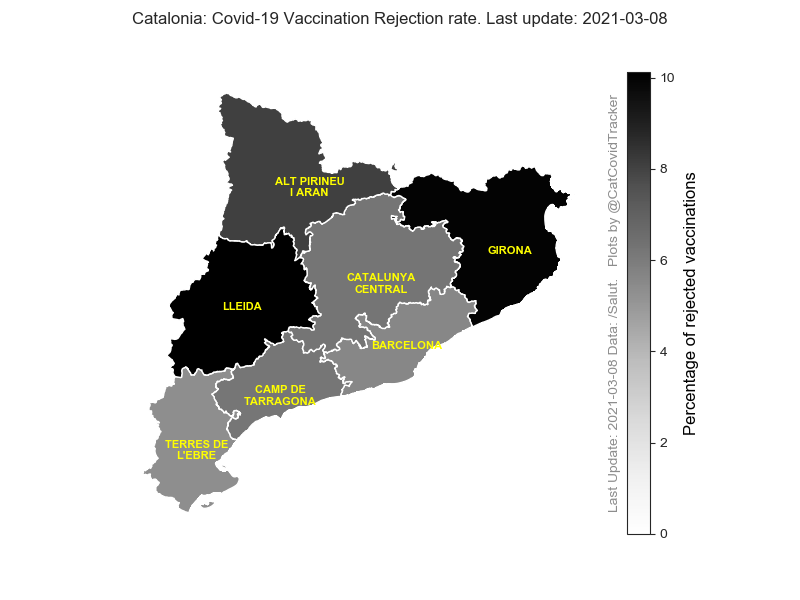

In [661]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Catalonia: Covid-19 Vaccination Rejection rate. Last update: " + last_update)
ax.axis("off")
dfmap.plot(ax=ax,column='rejection_rate',  legend=True,cmap='Greys',  
#           legend_kwds={'label': '% Rejected'},
           vmin=0)


dfmap['coords'] = dfmap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfmap['coords'] = [coords[0] for coords in dfmap['coords']]

for idx, row in dfmap.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],
                 horizontalalignment='center', fontsize = 8,fontweight='bold',color="yellow",verticalalignment="top")
ax.text(1.04, 0.5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax.transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')
ax.text(1.2, 0.5, "Percentage of rejected vaccinations", transform=ax.transAxes,
        fontsize=12, color='black', 
        ha='center', va='center', rotation='90')
plt.savefig('MapCurrentRegionRejectionCat.png')

In [662]:
fab = pd.DataFrame(casesdf.groupby(["FABRICANT"])["VACUNAT"].count())
fab["percentage"] = 100* fab["VACUNAT"]/sum(fab.VACUNAT)
fab

,VACUNAT,percentage
FABRICANT,,
BioNTech / Pfizer,77893,73.401559
Moderna / Lonza,14079,13.267181
Oxford / AstraZeneca,14147,13.331260


<IPython.core.display.Javascript object>


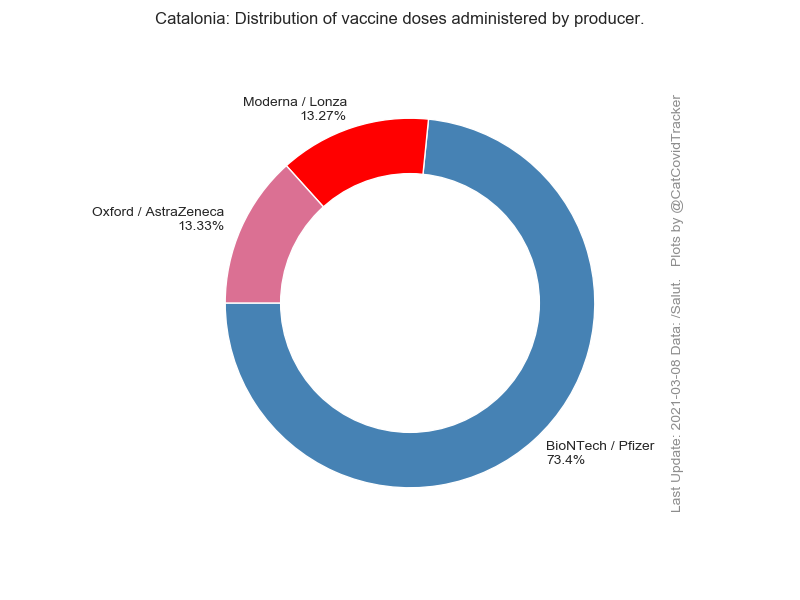

In [663]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Catalonia: Distribution of vaccine doses administered by producer.")


names = list(map(str.__add__, fab.index+"\n", fab.percentage.round(2).astype(str)+"%"))
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.pie(fab.percentage, labels=names, colors=["steelblue","red","palevioletred"],startangle=180)
p = plt.gcf()
p.gca().add_artist(my_circle)


ax.text(1.08, 0.5, "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=ax.transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')
# Show the graph
plt.show()

plt.savefig('VaccineProducer.png')

In [664]:
casesvacdf = casesdf[casesdf.VACUNAT==1]
casesvaccount = pd.DataFrame(casesvacdf.groupby(["DATA","DOSI","FABRICANT"]).agg('count')["VACUNAT"])
casesvaccount.reset_index(inplace = True)
casesvaccount["DATA"] = pd.to_datetime(casesvaccount["DATA"],format="%d/%m/%Y")
casesvaccount.sort_values(by="DATA",ascending=True,inplace=True)
casesvaccount = casesvaccount.groupby(["DATA","FABRICANT","DOSI"])['VACUNAT'].sum().groupby(level=['FABRICANT','DOSI']).cumsum().reset_index(name='Cumsum')


In [665]:
vac1 = casesvaccount[casesvaccount.DOSI==1]
vac2 = casesvaccount[casesvaccount.DOSI==2]
vac1.drop("DOSI",axis=1,inplace=True)
vac2.drop("DOSI",axis=1,inplace=True)
vac1 = vac1.set_index(["DATA","FABRICANT"]).unstack()
vac2 = vac2.set_index(["DATA","FABRICANT"]).unstack()
vac1.columns = vac1.columns.droplevel()
vac2.columns = vac2.columns.droplevel()

In [666]:
vac1.iloc[0].fillna(0,inplace=True)
vac2.iloc[0].fillna(0,inplace=True)
vac1.fillna(method='ffill',inplace=True)
vac2.fillna(method='ffill',inplace=True)

In [667]:
fabs = list(fab.index)


<IPython.core.display.Javascript object>


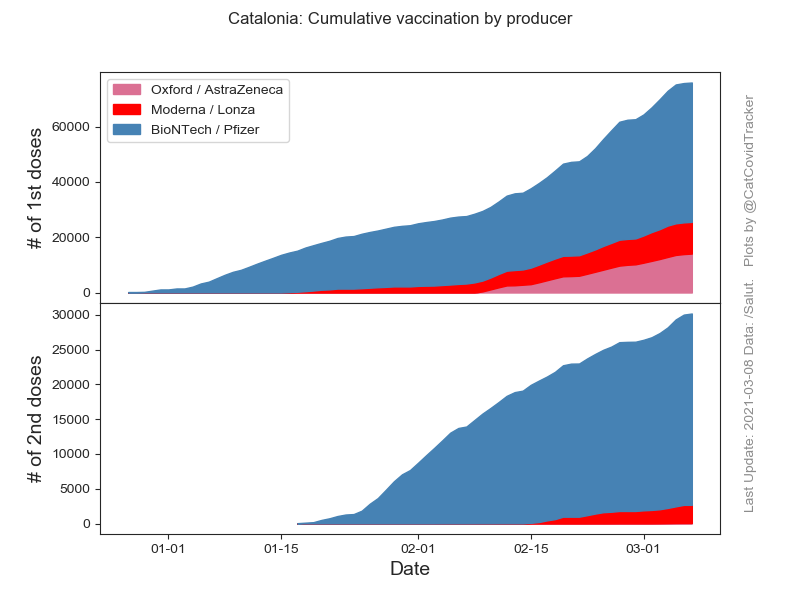

In [668]:

fig, axs = plt.subplots(2,   figsize=(8,6),sharex=True)
fig.suptitle("Catalonia: Cumulative vaccination by producer")
old1 = 0
old2 = 0

colfab =["steelblue","red","palevioletred"]
for i in reversed(range(3)):
    dose1 = vac1[fabs[i]]
    dose2 = vac2[fabs[i]]
    new1 = dose1+old1
    new2 = dose2 + old2
    axs[0].fill_between(dose1.index.get_level_values(0), old1, new1, color=colfab[i], label=fabs[i])
    axs[1].fill_between(dose2.index.get_level_values(0), old2, new2, color=colfab[i], label=fabs[i])
    old1=new1
    old2=new2
axs[0].legend(loc="upper left")
axs[0].set_ylabel("# of 1st doses",fontsize=14)
axs[1].set_ylabel("# of 2nd doses",fontsize=14)
axs[1].set_xlabel("Date",fontsize=14)
axs[1].xaxis.set_major_formatter(date_form) 

axs[1].text(1.05, 1., "Last Update: " + last_update + " Data: /Salut.   Plots by @CatCovidTracker", transform=axs[1].transAxes,
        fontsize=10, color='gray', alpha=0.9,
        ha='center', va='center', rotation='90')
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig('VaccineProducerByDate.png')

Convert png to jpg for instagram and report if files have been updated

In [669]:
import os
os.system("./jpg.sh")
print("Data updated?", toget)


Data updated? True


<IPython.core.display.Javascript object>


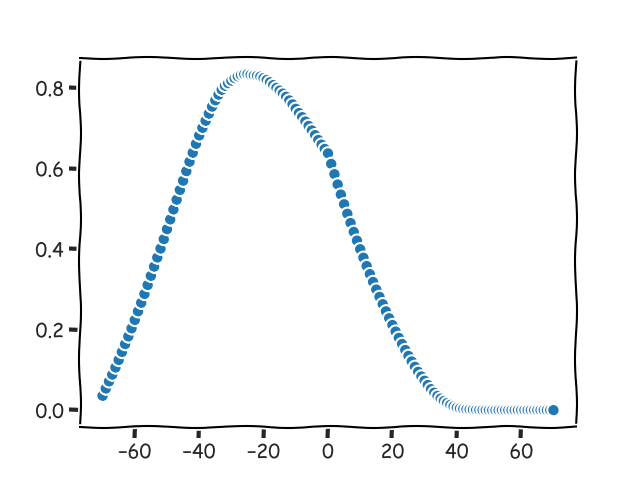

In [670]:
import numpy as np
x = dfaggvac["2nd dose percent"]
y = dfaggvac["INGRESSATS_TOTAL"]

with plt.xkcd():
    fig = plt.figure()
    ax = plt.axes()
    a = ax.xcorr(y, x, usevlines=False, maxlags=70, normed=True, lw=2)

In [671]:
xc = pd.DataFrame(a[1],a[0],columns=["xcorr"])
maxxc = np.max(xc)
maxdelay = xc['xcorr'].idxmax()
print("Max cross-correlation of ", maxxc.values[0],"at a delay of ", maxdelay ," days")

Max cross-correlation of  0.8339667587773795 at a delay of  -25  days
